<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"> <li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

## Подготовка данных

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score,recall_score,f1_score,precision_score,roc_auc_score

In [2]:
data = pd.read_csv('/datasets/Churn.csv')
data.sample(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
4225,4226,15671804,Wilding,648,Spain,Male,36,8.0,146943.38,2,1,1,130041.45,0
6331,6332,15701074,Herz,629,Germany,Male,35,8.0,112330.83,1,1,1,91001.02,0
7206,7207,15770995,Sinclair,753,Germany,Female,47,1.0,131160.85,1,1,0,197444.69,0
6628,6629,15584967,Chiganu,596,Spain,Male,57,6.0,0.00,2,1,1,72402.00,0
6341,6342,15658364,Laney,807,Germany,Female,40,1.0,134590.21,1,1,1,46253.65,0
8837,8838,15809736,Steigrad,664,France,Male,46,2.0,0.00,1,1,1,177423.02,1
3354,3355,15751333,Atkinson,695,France,Female,36,2.0,0.00,2,0,1,167749.54,0
3978,3979,15669490,Ifeanacho,837,Germany,Male,37,6.0,94001.61,2,1,0,140723.05,0
9984,9985,15696175,Echezonachukwu,602,Germany,Male,35,7.0,90602.42,2,1,1,51695.41,0
6309,6310,15785342,Shipp,705,France,Male,25,9.0,0.00,2,0,1,112331.19,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
#проверим количество NAN в столбцах
data.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [5]:
#удалим NAN в Tenure
data.dropna(subset=['Tenure'], inplace=True)

In [6]:
#проверим уникальные значения в столбце Gender
data['Gender'].unique()

array(['Female', 'Male'], dtype=object)

In [7]:
#уберем лишний столбец RowNumber и ненужный Surname
data = data[['CustomerId', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']]

In [8]:
#проверим на дубликаты
all(data.duplicated())

False

In [9]:
data.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,9.091000e+03,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000
mean,1.569105e+07,650.736553,38.949181,4.997690,76522.740015,1.530195,0.704983,0.515565,100181.214924,0.203938
std,7.161419e+04,96.410471,10.555581,2.894723,62329.528576,0.581003,0.456076,0.499785,57624.755647,0.402946
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,1.562899e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.000000,0.000000,51227.745000,0.000000
50%,1.569106e+07,652.000000,37.000000,5.000000,97318.250000,1.000000,1.000000,1.000000,100240.200000,0.000000
75%,1.575285e+07,717.000000,44.000000,7.000000,127561.890000,2.000000,1.000000,1.000000,149567.210000,0.000000
max,1.581566e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


**Вывод**

Вопрос с пропусками решён, лишний столбец удален, проверка на повторяющиеся строки выполнена.

В данных имеются категориальные признаки, их нужно преобразовать в численные для дальнейшей работы с данными.
Чтобы устранить дисбаланс классов и даллее работать с данными, необходимо закодировать данные в столбцах Gender и Geography. Преобразовать категориальные признаки в численные поможет техника прямого кодирования, или отображения (англ. One-Hot Encoding, OHE). Для прямого кодирования в библиотеке pandas есть функция pd.get_dummies()

In [10]:
data = pd.get_dummies(data, drop_first=False)

In [11]:
data.sample(5)

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
9073,15611058,702,60,5.0,138597.54,2,1,1,41536.59,1,0,1,0,1,0
339,15807923,716,39,10.0,115301.31,1,1,0,43527.40,1,0,1,0,1,0
2641,15599301,538,28,6.0,164365.44,1,0,1,5698.97,0,0,1,0,1,0
4027,15718280,662,39,5.0,139822.11,2,1,1,146219.90,0,0,1,0,0,1
6623,15610753,581,28,3.0,104367.50,1,1,1,29937.75,0,1,0,0,0,1


## Исследование задачи

Исследуйте баланс классов, обучите модель без учёта дисбаланса. Кратко опишите выводы.

In [12]:
target_0 = data[data['Exited'] == 0]['Exited'].count()
target_1 = data[data['Exited']== 1]['Exited'].count()
print(target_0,target_1)

7237 1854


No handles with labels found to put in legend.


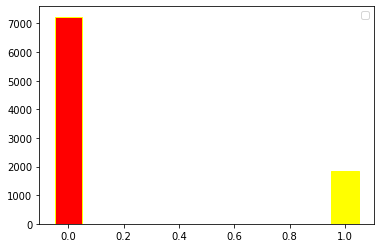

In [13]:
labels = [0,1]
plt.bar(labels[0],target_0, width=0.1,color = 'red',edgecolor='yellow')
plt.bar(labels[1],target_1,width=0.1,color = 'yellow',edgecolor='yellow')
plt.legend()

Данные несбалансированы, потому что у нас есть 80% нулей и 20% нулей, которые могут создавать проблемы с предсказанием.

In [14]:
#Разделим исходные данные на обучающую, валидационную и тестовую выборки
target = data['Exited']
features = data.drop('Exited', axis=1)

features_train, features_test, target_train, target_test  = train_test_split(features, target, train_size=0.6, random_state=1)
features_test, features_valid, target_test, target_valid = train_test_split(features_test, target_test, test_size=0.5, random_state=1)

In [15]:
#1.Дерево решений

best_model = None
best_result = 0
for depth in range(1, 10):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_result:
        best_model = model
        best_result = f1           
print("F1:", best_result,'с глубиной:', best_model.max_depth)

F1: 0.58252427184466 с глубиной: 6


In [79]:
#2.Случайный лес подбор глубины
best_model = None
best_result = 0
for depth in range(1, 10):
    model = RandomForestClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_result:
        best_model = model
        best_result = f1           
print("F1:", best_result,'с глубиной:', best_model.max_depth)

F1: 0.5344827586206896 с глубиной: 9


In [90]:
#2.Случайный лес подбор числа деревьев
best_model = None
best_result = 0
for est in range(1, 150, 10):
    model = RandomForestClassifier(random_state=12345, max_depth=9, n_estimators=est)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_result:
        best_model = model
        best_result = f1           
print("F1:", best_result,'с количеством деревьев:', best_model.n_estimators)

F1: 0.545138888888889 с количеством деревьев: 101


In [19]:
#1.Дерево решений 
model = DecisionTreeClassifier(random_state=12345, max_depth=6)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.58252427184466


In [91]:
#2.Случайный лес
model = RandomForestClassifier(random_state=12345, max_depth=9, n_estimators=101)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.545138888888889


In [18]:
#3.Логистическая регрессия
model = LogisticRegression(random_state=12345) 
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.0


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


## Борьба с дисбалансом

Для борьбы с дисбалансом могут быть использованы следующие методы:
 - Взвешивание классов (class_weight)
 - Увеличение выборки (upsampling)
 - Уменьшение выборки (downsampling)

F1 = 0.494


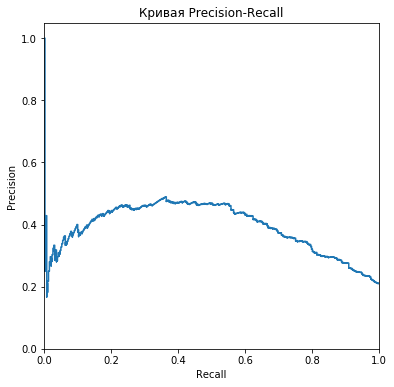

In [19]:
#взвешивание классов
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

f1 = f1_score(target_valid, predicted_valid)
print("F1 = {:.3f}".format(f1))

probabilities_valid = model.predict_proba(features_valid)
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])


plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show() 

F1 = 0.374


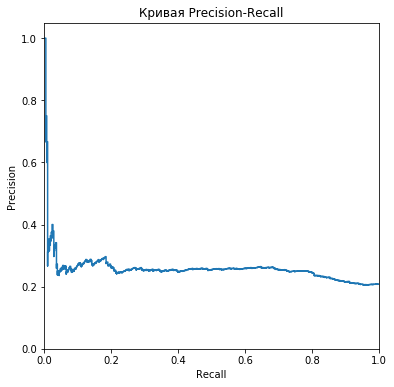

In [40]:
#увеличение выборки
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

f1 = f1_score(target_valid, predicted_valid)
print("F1 = {:.3f}".format(f1))

probabilities_valid = model.predict_proba(features_valid)
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])
plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show() 

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


F1 = 0.377


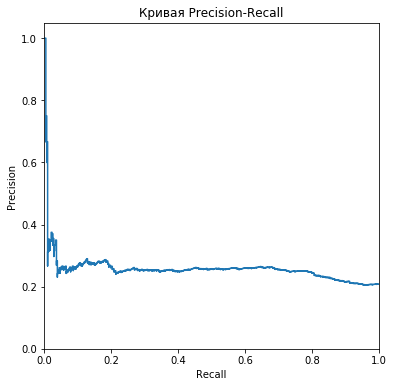

In [47]:
#уменьшение выборки
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.2)

model = LogisticRegression(random_state=12345)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
f1 = f1_score(target_valid, predicted_valid)
print("F1 = {:.3f}".format(f1))


probabilities_valid = model.predict_proba(features_valid)
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])
plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show() 

На графиках изображены значения метрик при изменении порога.
По вертикали - точность, по горизонтали — полнота. Кривая, показывающая их значения, называется PR-кривой, и чем выше кривая, тем лучше модель.

Взвешивание классов дало лучший результат метрики F1.

## Тестирование модели

In [81]:
#1.Дерево решений
model = DecisionTreeClassifier(random_state=12345, max_depth=10)
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)

accuracy = model.score(features_test, target_test)
precision = precision_score(target_test, predicted_test)
recall = recall_score(target_test, predicted_test)
f1 = f1_score(target_test, predicted_test)

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)

print("Качество = {:.3f}, Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.3f}, AUC-ROC = {:.3f}".format(accuracy, precision, recall, f1, auc_roc))

Качество = 0.821, Точность = 0.548, Полнота = 0.436, F1 = 0.486, AUC-ROC = 0.749


In [97]:
#2.Случаный лес
model = RandomForestClassifier(random_state=12345, max_depth=9, n_estimators=100, class_weight='balanced')
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)

accuracy = model.score(features_test, target_test)
precision = precision_score(target_test, predicted_test)
recall = recall_score(target_test, predicted_test)
f1 = f1_score(target_test, predicted_test)

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)

print("Качество = {:.3f}, Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.3f}, AUC-ROC = {:.3f}".format(accuracy, precision, recall, f1, auc_roc))

Качество = 0.839, Точность = 0.580, Полнота = 0.615, F1 = 0.597, AUC-ROC = 0.841


In [83]:
#3.Логистическая регрессия

model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced') 
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)

accuracy = model.score(features_test, target_test)
precision = precision_score(target_test, predicted_test)
recall = recall_score(target_test, predicted_test)
f1 = f1_score(target_test, predicted_test)

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)

print("Качество = {:.3f}, Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.3f}, AUC-ROC = {:.3f}".format(accuracy, precision, recall, f1, auc_roc))

Качество = 0.695, Точность = 0.341, Полнота = 0.609, F1 = 0.437, AUC-ROC = 0.708


## Вывод
Данные были анализированы и обработаны, удалены пропуски и ненужные столбцы, проверка на дуюликаты выполнена.

Имеющиеся в данных категориальные признаки преобразованы в численные с помощью техники прямого кодирования.

В ходе исследования были найдены следующие особенности:

- Лучшей моделью оказалась RandomForestClassifier
- Самый высокий показатель F1-метрики 0.597
- Лучший показатель метрики AUC-ROC = 0.841
- Параметры модели RandomForest, дающие лучший результат - глубина=9, количество деревьев=100
- Для борьбы с дисбалансом лучше всего сработал метод взвешивания классов